In [118]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od

def read_current_time():
    from datetime import datetime
    now = datetime.now()

    return "%d%02d%02d-%02d:%02d:%02d"%(now.year, now.month, now.day,
                                        now.hour, now.minute, now.second)


def load_pickle(fname):
    with open(fname, "rb") as fp:
        return pkl.load(fp)

In [2]:
# tag = "_mfast"
# tag = "_mslow2"
tag = ""
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data"+tag, load_only_control=True)
srate = 2000

fdir_fig_out = "./figs/spec_hist"+tag

# Sample figure

In [635]:
detail_data = summary_obj.load_detail(4, 0)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(5, 105), mbin_t=0.01, wbin_t=0.5, srate=srate)

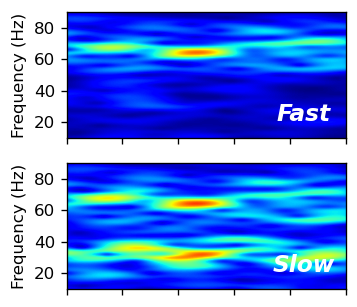

In [651]:
xl = (6, 7)
yl = (10, 90)

fig, axs = plt.subplots(2, 1,figsize=(3, 3))
for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n+1], x=tpsd, y=fpsd, cmap="jet", vmin=None, vmax=None, interpolation="bicubic")
    plt.xlim(xl)
    plt.ylim(yl)
    plt.ylabel("Frequency (Hz)", fontsize=10)
    plt.yticks(np.arange(20, 90, 20))
    
xt = axs[1].get_xticks()
axs[0].set_xticklabels("")
axs[1].set_xticklabels("")

opt = dict(va="center", ha="center", color="w", fontsize=14, fontweight="bold", fontstyle="italic")
axs[0].text(xl[1]-0.15, 25, "Fast", **opt)
axs[1].text(xl[1]-0.15, 25, "Slow", **opt)

plt.show()

# Tune detection frequency range

In [443]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def f_cauchy(x, a0, b0, x0, g0):
    return a0/np.pi*(g0/((x-x0)**2+g0**2)) + b0

def f_cauchy2(x, a0, b0, x0, g0, a1, b1, x1, g1):
    y0 = f_cauchy(x, a0, b0, x0, g0)
    y1 = f_cauchy(x, a1, b1, x1, g1)
    return y0 + y1

def fit_distrib(x, y, init_point, bound_point):
    key_init_set = ("a0", "b0", "f0", "g0")
    key_bound_set = ("ab", "bb", "fb", "gb")
    if len(init_point["a0"]) == 1:
        p0 = [init_point[k][0] for k in key_init_set]
        bmin = [bound_point[k][0][0] for k in key_bound_set]
        bmax = [bound_point[k][0][1] for k in key_bound_set]
        params, _ = curve_fit(f_cauchy, x, y, p0=p0, bounds=(bmin, bmax))
        
    elif len(init_point["a0"]) == 2:
        p0, bmin, bmax = [], [], []
        for n in range(2):
            p0.extend([init_point[k][n] for k in key_init_set])
            bmin.extend([bound_point[k][n][0] for k in key_bound_set])
            bmax.extend([bound_point[k][n][1] for k in key_bound_set])
        params, _ = curve_fit(f_cauchy2, x, y, p0=p0, bounds=(bmin, bmax))
        
    else:
        raise ValueError("Unexpected # of init vars")
    
    return params

amp_range_set = [[] for _ in range(summary_obj.num_controls[0])]

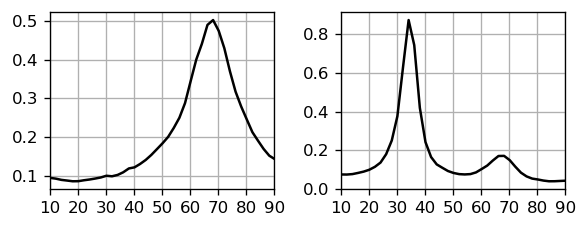

In [504]:
cid = 10

yf = [0, 0]
ntrial = 20
for n in range(ntrial):
    detail_data = summary_obj.load_detail(cid-1, n)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(10, 100), mbin_t=0.01, wbin_t=0.5, srate=srate)
    yf[0] += psd_set[1].mean(axis=1)
    yf[1] += psd_set[2].mean(axis=1)
    
yf[0] /= ntrial
yf[1] /= ntrial

plt.figure(figsize=(5, 2), dpi=120)
for n in range(2):
    plt.subplot(1,2,n+1)
    plt.plot(fpsd, yf[n], c='k')
    plt.xticks(np.arange(10, 100, 10))
    plt.grid(True)
    plt.xlim([10, 90])

plt.tight_layout()
plt.show()

In [503]:
# set initial parameters

10
init_point = [dict(a0=[5], b0=[0], f0=[35], g0=[10]),
              dict(a0=[5], b0=[0], f0=[35], g0=[10])]
bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]]),
               dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]])]

# # 9
# init_point = [dict(a0=[5], b0=[0], f0=[35], g0=[10]),
#               dict(a0=[5], b0=[0], f0=[35], g0=[10])]
# bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]]),
#                dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]])]

# # 8
# init_point = [dict(a0=[5], b0=[0], f0=[35], g0=[10]),
#               dict(a0=[5], b0=[0], f0=[35], g0=[10])]
# bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]]),
#                dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 80]], gb=[[0, 50]])]

# # 7
# init_point = [dict(a0=[5, 5], b0=[0, 0], f0=[25, 65], g0=[10, 10]),
#               dict(a0=[5, 5], b0=[0, 0], f0=[25, 65], g0=[10, 10])]
# bound_point = [dict(ab=[[0, 20], [0, 20]], bb=[[0, 10], [0, 10]], fb=[[0, 45], [50, 80]], gb=[[0, 50], [0, 50]]),
#                dict(ab=[[0, 20], [0, 20]], bb=[[0, 10], [0, 10]], fb=[[0, 45], [50, 80]], gb=[[0, 50], [0, 50]])]

# # 6
# init_point = [dict(a0=[5], b0=[0], f0=[65], g0=[10]),
#               dict(a0=[5], b0=[0], f0=[65], g0=[10])]
# bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[50, 80]], gb=[[0, 50]]),
#                dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[50, 80]], gb=[[0, 50]])]

# # # 5
# init_point = [dict(a0=[5], b0=[0], f0=[65], g0=[10]),
#               dict(a0=[5, 5], b0=[0, 0], f0=[30, 65], g0=[10, 10])]
# bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[50, 80]], gb=[[0, 50]]),
#                dict(ab=[[0, 10], [0, 10]], bb=[[0, 10], [0, 10]], fb=[[10, 40], [50, 80]], gb=[[0, 50], [0, 50]])]

# # 4
# init_point = [dict(a0=[5, 5], b0=[0, 0], f0=[35, 65], g0=[10, 10]),
#               dict(a0=[5, 5], b0=[0, 0], f0=[35, 65], g0=[10, 10])]
# bound_point = [dict(ab=[[0, 10], [0, 10]], bb=[[0, 10], [0, 10]], fb=[[10, 45], [50, 80]], gb=[[0, 50], [0, 50]]),
#                dict(ab=[[0, 10], [0, 10]], bb=[[0, 10], [0, 10]], fb=[[10, 45], [50, 80]], gb=[[0, 50], [0, 50]])]

# # 3
# init_point = [dict(a0=[5, 5], b0=[0, 0], f0=[35, 65], g0=[10, 10]),
#               dict(a0=[5, 5], b0=[0, 0], f0=[35, 65], g0=[10, 10])]
# bound_point = [dict(ab=[[0, 10], [0, 10]], bb=[[0, 10], [0, 10]], fb=[[10, 45], [50, 80]], gb=[[0, 50], [0, 50]]),
#                dict(ab=[[0, 10], [0, 10]], bb=[[0, 10], [0, 10]], fb=[[10, 45], [50, 80]], gb=[[0, 50], [0, 50]])]

# # 2
# init_point = [dict(a0=[5], b0=[0], f0=[40], g0=[10]),
#               dict(a0=[5], b0=[0], f0=[40], g0=[10])]
# bound_point = [dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 40]], gb=[[0, 50]]),
#                dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 40]], gb=[[0, 50]])]

#  # 1
# init_point = [dict(a0=[0.1, 0.1], b0=[0, 0], f0=[25, 40], g0=[10, 10]),
#               dict(a0=[5], b0=[0], f0=[25], g0=[10])]
# bound_point = [dict(ab=[[0, 10], [0.05, 10]], bb=[[0, 10], [0, 10]], fb=[[20, 35], [35, 50]], gb=[[0, 50], [0, 50]]),
#                dict(ab=[[0, 10]], bb=[[0, 10]], fb=[[10, 40]], gb=[[0, 50]])]

[10.          0.10024612 67.74157969  7.79281677]
[ 8.37768516  0.06801819 34.35631149  3.19570968]


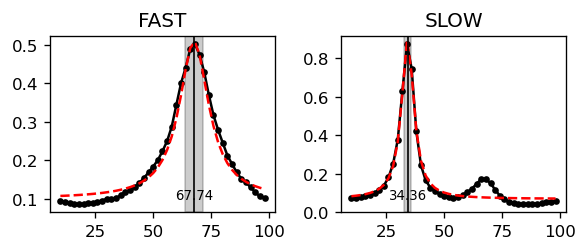

{'fpop': [[], array([63.85, 71.64])], 'spop': [array([32.76, 35.95]), []]}


In [505]:
c = 0.5
keys = ("fpop", "spop")
amp_range = dict()

fig, axs = plt.subplots(1,2,figsize=(5, 2.2))
for n in range(2):
    ax = axs[n]
    ax.plot(fpsd, yf[n], 'k.-')
    pfit = fit_distrib(fpsd, yf[n], init_point[n], bound_point[n])
    print(pfit)
    
    amp_range[keys[n]] = [[], []]
    yl = ax.get_ylim()
    y0 = yl[0] + (yl[1]-yl[0])/10
    
    if len(pfit)//4 == 1:
        ax.plot(fpsd, f_cauchy(fpsd, *pfit), 'r--')
        fl = np.round((pfit[2]-c*pfit[3], pfit[2]+c*pfit[3]), 2)
        ax.fill_betweenx(yl, fl[0], fl[1], color='k', alpha=0.2)
        amp_range[keys[n]][1-n] = fl
        ax.vlines(pfit[2], yl[0], yl[1], color='k', linewidth=1)
        ax.text(pfit[2], y0, "%.2f"%(pfit[2]), fontsize=8, va="center", ha="center")
        
    if len(pfit)//4 == 2:
        ax.plot(fpsd, f_cauchy2(fpsd, *pfit), 'r--')
        fl = np.round((pfit[2]-c*pfit[3], pfit[2]+c*pfit[3]), 2)
        ax.fill_betweenx(yl, fl[0], fl[1], color='k', alpha=0.2)
        amp_range[keys[n]][0] = fl
        ax.vlines(pfit[2], yl[0], yl[1], color='k', linewidth=1)
        ax.text(pfit[2], y0, "%.2f"%(pfit[2]), fontsize=8, va="center", ha="center")
        
        fl = np.round((pfit[6]-c*pfit[7], pfit[6]+c*pfit[7]), 2)
        ax.fill_betweenx(yl, fl[0], fl[1], color='k', alpha=0.2)
        amp_range[keys[n]][1] = fl
        ax.vlines(pfit[6], yl[0], yl[1], color='k', linewidth=1)
        ax.text(pfit[6], y0, "%.2f"%(pfit[6]), fontsize=8, va="center", ha="center")

    ax.set_ylim(yl)
    
# plt.suptitle("CID = %d"%(cid), fontsize=14)
axs[0].set_title("FAST", fontsize=12)
axs[1].set_title("SLOW", fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(fdir_fig_out, "cid_%d.png"%(cid)), bbox_inches="tight", dpi=200)

plt.show()
print(amp_range)

amp_range_set[cid-1] = amp_range

In [506]:
amp_range_set

[{'fpop': [array([23.93, 28.37]), array([32.35, 48.03])],
  'spop': [array([22.34, 29.24]), []]},
 {'fpop': [[], array([29.64, 44.17])], 'spop': [[], array([20.98, 41.41])]},
 {'fpop': [array([33.36, 36.42]), array([55.97, 68.93])],
  'spop': [array([32.86, 36.71]), array([65.64, 70.16])]},
 {'fpop': [array([31.33, 35.27]), array([50.65, 68.84])],
  'spop': [array([30.22, 35.97]), array([50.72, 65.06])]},
 {'fpop': [[], array([61.08, 71.01])],
  'spop': [array([26.95, 34.81]), array([60.52, 71.06])]},
 {'fpop': [[], array([63.02, 71.33])], 'spop': [[], array([62.97, 71.33])]},
 {'fpop': [array([33.82, 36.85]), array([63.09, 74.15])],
  'spop': [array([33.35, 37.4 ]), array([65.6 , 71.09])]},
 {'fpop': [[], array([32.31, 45.69])], 'spop': [array([22.32, 28.84]), []]},
 {'fpop': [[], array([50.33, 66.4 ])], 'spop': [array([29.6, 34. ]), []]},
 {'fpop': [[], array([63.85, 71.64])], 'spop': [array([32.76, 35.95]), []]}]

## Save

In [507]:
key_names = ("fpop", "spop")

fname = "./data/osc_motif%s/amp_range_set.pkl"%(tag)
with open(fname, "wb") as fp:
    pkl.dump({"amp_range_set": amp_range_set,
              "source_dir": summary_obj.fdir,
              "last-updated": read_current_time()}, fp)
    
# frequency range are determined based on fourier transform result

# Oscillation motif example figure

# Statistics of osc motif

In [133]:
def get_num_motif(motif_data):
    return np.array([len(w) for w in motif_data["winfo"]])

In [550]:
cid = 7

motif_data = load_pickle("./data/osc_motif/motif_info_%d.pkl"%(cid))
num_motif = get_num_motif(motif_data)

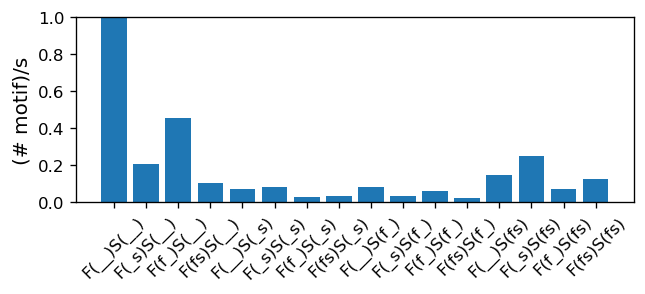

In [551]:
tmax = 10
num_itr = 800
x = np.arange(len(num_motif))

fig = plt.figure(figsize=(6, 2))
plt.bar(x, num_motif/tmax/num_itr)
plt.ylabel("(# motif)/s", fontsize=12)
plt.xticks(x, od.get_motif_labels(), rotation=45)
plt.ylim([0, 1])

# fname = "./figs/spec_hist%s/num_motif_%d.png"%(tag, cid)
plt.show()

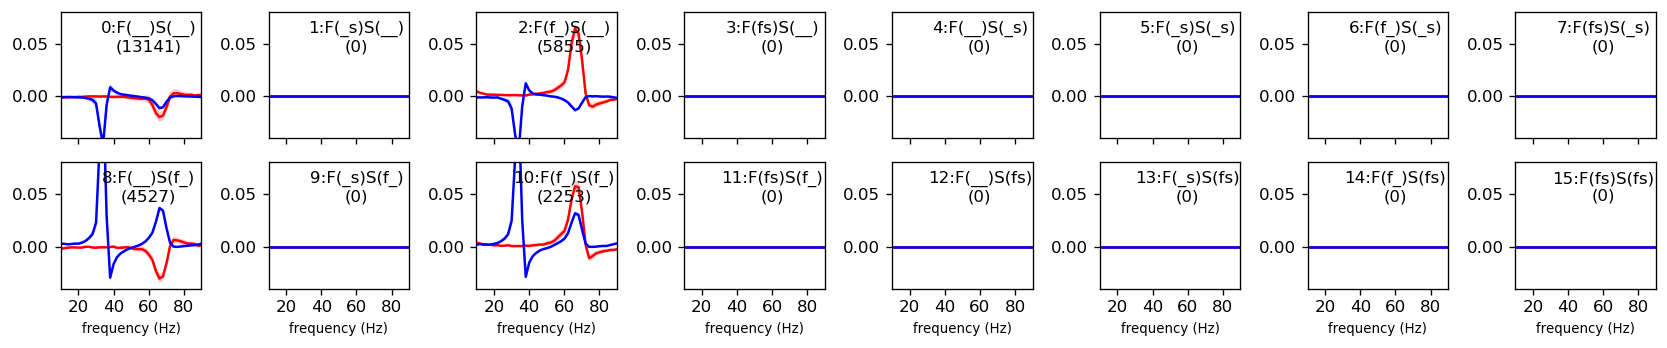

In [535]:
cs = ["r", "b"]

cid = 10
spec_data = load_pickle("./data/osc_motif/spec_summary/spec_summary_%d.pkl"%(cid))

x = spec_data["fpsd"]
fig, axs = plt.subplots(2, 8, figsize=(14, 3.))
for n in range(16):
    n0, n1 = n//8, n%8
    ax = axs[n0][n1]
    
    for i in range(2):
        y = spec_data["spec_boot"][n][:,i,:]
        m = y.mean(axis=0)
        s = y.std(axis=0)
        
        ax.plot(x, m, c=cs[i])
        ax.fill_between(x, m+s, m-s, color=cs[i], edgecolor="none", alpha=0.2)
        
    ax.set_xticks(np.arange(0, 110, 20))
    ax.set_xlim([10, 90])
    
    ax.set_ylim([-0.04, 0.08])
    yl = ax.get_ylim()
    assert yl[0]*yl[1] < 0
    
    if yl[1] > -yl[0]:
        yt = yl[1] - (yl[1]-yl[0])/10*2
    else:
        yt = yl[0] + (yl[1]-yl[0])/10*2
    
    txt = "%d:%s\n(%d)"%(n, od.get_motif_labels()[n], spec_data["num_winfo"][n])
    ax.text(60, yt, txt, va="center", ha="center", fontsize=10)
    
    if n0 == 0:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("frequency (Hz)", fontsize=8)

plt.tight_layout()

fname = "./figs/spec_hist%s/motif_summary_%d.png"%(tag, cid)
fig.savefig(fname, dpi=200, bbox_inches="tight")
plt.show()

In [1026]:
cid = 4

spec_data = load_pickle("./data/osc_motif/spec2d_summary/spec2d_summary_%d.pkl"%(cid))

t = spec_data["tpsd"]
f = spec_data["fpsd"]

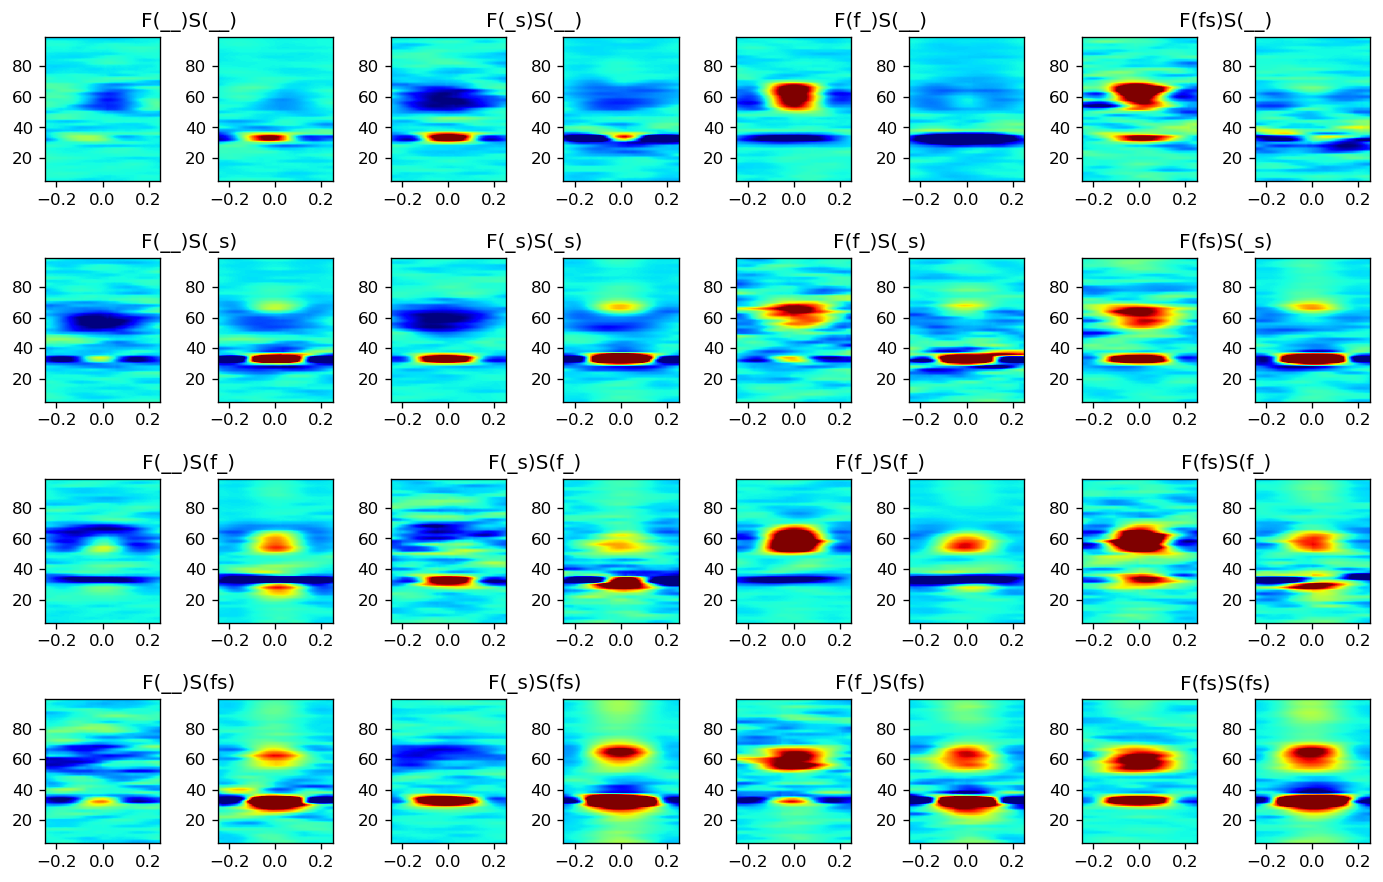

In [997]:
h0 = 0.08
w0 = 0.04
w0_sub = 0.04

hw = (1-5*h0)/4
ww = (1-5*w0)/4
ww_sub = (ww - w0_sub)/2

plt.figure(figsize=(12, 8))

wid = 0
h = 1-hw-h0
ax_set = []
for nr in range(4):
    w = ww+w0
    for nc in range(4):
        ax = plt.axes(position=(w, h, ww, hw))
        ax_set.append(ax)
        plt.axis("off")
        
        wtmp = w
        if len(spec_data["spec_boot"][wid]) > 0:
            for i in range(2):
                plt.axes(position=(wtmp, h, ww_sub, hw))
                hhtools.imshow_xy(spec_data["spec_boot"][wid][i], cmap="jet", x=t, y=f, vmax=0.05, vmin=-0.03)
                
                plt.xlim([-0.25, 0.25])
                plt.xticks([-0.2, 0, 0.2])
                plt.yticks(np.arange(20, 100, 20))
                
                wtmp += ww_sub+w0_sub
            

        wid += 1
        w += ww+w0
    h -= hw+h0
    

for wid in range(16):
    plt.sca(ax_set[wid])
    
    # yl = plt.ylim()
    # plt.plot([0,0], yl, 'k--', lw=1)
    # plt.ylim(yl)
    
    plt.title(od.get_motif_labels()[wid])
    if wid % 4 == 0:
        plt.ylabel(r"$f$ (Hz)", fontsize=12)
    if wid // 4 == 3:
        plt.xlabel(r"$t$ (ms)", fontsize=12)
        
plt.show()

In [1055]:
cid = 7

spec_data = load_pickle("./data/osc_motif/spec2d_summary/spec2d_summary_%d.pkl"%(cid))

t = spec_data["tpsd"]
f = spec_data["fpsd"]

In [ ]:
fig_dir = "./figs/spec2d_summary/"

for wid in range(16):
    if len(spec_data["spec_boot"][wid]) == 0: continue

    plt.figure(figsize=(4.5, 2))

    tp_labels = ("Fast", "Slow")
    for n in range(2):
        # plt.subplot(1,2,n+1)
        plt.axes(position=(0.2+0.5*n, 0.15, 0.35, 0.75))
        hhtools.imshow_xy(spec_data["spec_boot"][wid][n], cmap="jet", x=t, y=f, vmax=0.1, vmin=-0.03,
                         interpolation="bicubic")
        plt.xticks([-0.3, 0, 0.3])
        plt.ylim([10, 90])
        # plt.colorbar()

        plt.xlabel("time (s)", fontsize=13)
        plt.ylabel("frequency (Hz)", fontsize=13)
        plt.text(-0.1, 17, tp_labels[n], fontsize=12, va='center', ha='center', color='w', fontweight='bold')
    
    plt.savefig(os.path.join(fig_dir, "spec2d_%d%02d.png"%(cid, wid)), dpi=120, bbox_inches="tight")
    # plt.clf()
    plt.show()
    # break

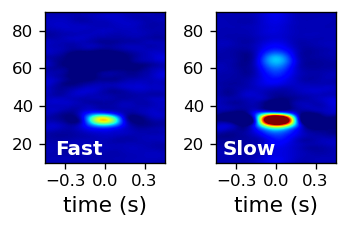

In [ ]:
plt.figure(figsize=(3, 2))

tp_labels = ("Fast", "Slow")
for n in range(2):
    plt.subplot(1,2,n+1)
    hhtools.imshow_xy(spec_data["spec_boot"][nw][n], cmap="jet", x=t, y=f, vmax=0.2, vmin=-0.01,
                     interpolation="bicubic")
    plt.xticks([-0.3, 0, 0.3])
    plt.ylim([10, 90])
    
    plt.xlabel("time (s)", fontsize=13)
    plt.text(-0.2, 17, tp_labels[n], fontsize=12, va='center', ha='center', color='w', fontweight='bold')
    
plt.tight_layout()
plt.show()

F(_s)S(fs)


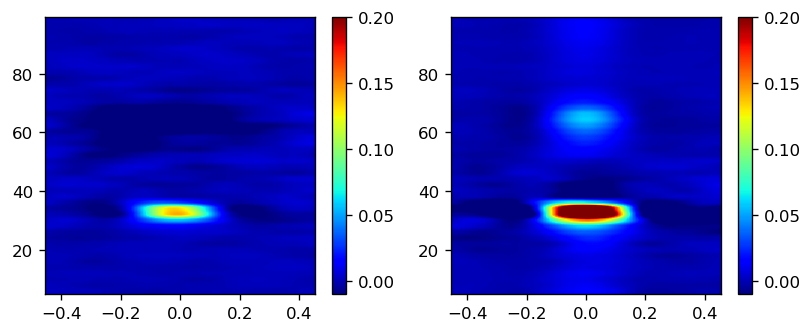

In [1027]:
nw = 13

print(od.get_motif_labels()[nw])

plt.figure(figsize=(8, 3))
for n in range(2):
    plt.subplot(1,2,n+1)
    hhtools.imshow_xy(spec_data["spec_boot"][nw][n], cmap="jet", x=t, y=f, vmax=0.2, vmin=-0.01)
    plt.colorbar()

F(_s)S(fs)


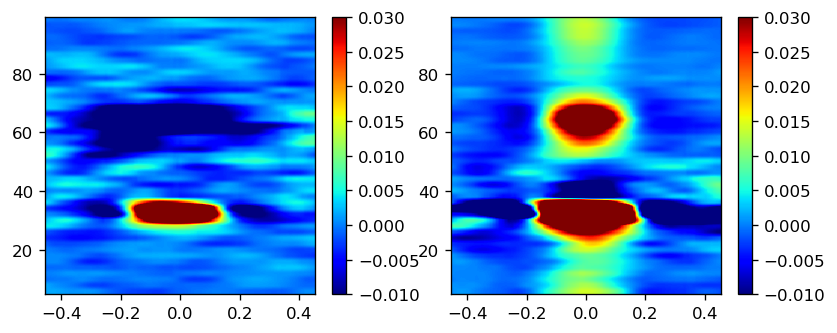

In [999]:
nw = 13

print(od.get_motif_labels()[nw])

plt.figure(figsize=(8, 3))
for n in range(2):
    plt.subplot(1,2,n+1)
    hhtools.imshow_xy(spec_data["spec_boot"][nw][n], cmap="jet", x=t, y=f, vmax=0.03, vmin=-0.01)
    plt.colorbar()

# Sample figure

In [1057]:
import utils


In [1062]:
od.get_motif_labels()[10]

'F(f_)S(f_)'

In [1123]:
winfo = utils.load_osc_motif(4, 10)

Loaded oscillation motif information udpated in 20240915


In [1131]:
import utils

wid = 14
cid_set = (4, 5)
nt_set = [20, 145]
# nt_set = [120, 140]
# nt_set = [0, 1]

psd_target = []
tl_target = []
for i, cid in enumerate(cid_set):
    winfo = utils.load_osc_motif(cid, wid, tag="", verbose=False)[0]
    nt, tl = winfo[nt_set[i]]
    
    tl_target.append(np.average(tl))
    detail_data = summary_obj.load_detail(cid-1, nt)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(5, 105), mbin_t=0.01, wbin_t=0.5, srate=srate)
    psd_target.append(psd_set)
    
print(od.get_motif_labels()[wid])

Loaded oscillation motif information udpated in 20240915
Loaded oscillation motif information udpated in 20240915
F(f_)S(fs)


In [1125]:
tl_target

[4.869999999999999, 10.025]

In [1106]:
vset = [[[0.05, 0.7], [0.05, 0.6]],
        [[0, 0.8], [0, 0.8]]]



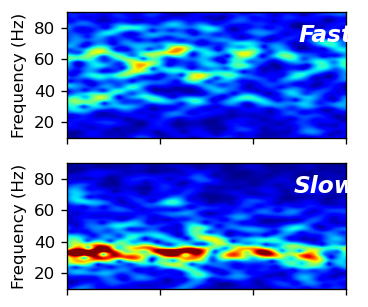

In [1128]:
vset = [[[0., 0.7], [0., 0.6]],
        [[0, 0.5], [0, 0.8]]]

nid = 0
psd_set = psd_target[nid]

# xl = (tl_target[nid] - 0.5, tl_target[nid] + 0.5)
# xl = (tl_target[nid] - 2, tl_target[nid] + 2)
# xl = [1.8, 3.5]
xl = [3, 6]
yl = (10, 90)

fig, axs = plt.subplots(2, 1,figsize=(3, 3))
for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n+1], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic",
                      vmin=vset[nid][n][0], vmax=vset[nid][n][1])
    plt.xlim(xl)
    plt.ylim(yl)
    plt.ylabel("Frequency (Hz)", fontsize=10)
    plt.yticks(np.arange(20, 90, 20))
    # plt.vlines(tl_target[nid], 0, 100, color='w')
    
xt = axs[1].get_xticks()
axs[0].set_xticklabels("")
axs[1].set_xticklabels("")

opt = dict(va="center", ha="center", color="w", fontsize=14, fontweight="bold", fontstyle="italic")
axs[0].text(xl[1]-0.22, 75, "Fast", **opt)
axs[1].text(xl[1]-0.22, 75, "Slow", **opt)

plt.show()

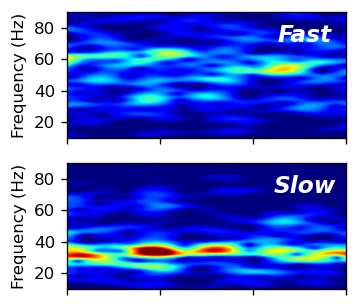

In [1138]:
vset = [[[0.05, 0.7], [0.05, 0.6]],
        [[0, 0.5], [0, 0.8]]]

nid = 0
psd_set = psd_target[nid]

# xl = (tl_target[nid] - 0.5, tl_target[nid] + 0.5)
# xl = (tl_target[nid] - 2, tl_target[nid] + 2)
# xl = [1.8, 3.5]
xl = [7, 8.5]
yl = (10, 90)

fig, axs = plt.subplots(2, 1,figsize=(3, 3))
for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n+1], x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic",
                      vmin=vset[nid][n][0], vmax=vset[nid][n][1])
    plt.xlim(xl)
    plt.ylim(yl)
    plt.ylabel("Frequency (Hz)", fontsize=10)
    plt.yticks(np.arange(20, 90, 20))
    # plt.vlines(tl_target[nid], 0, 100, color='w')
    
xt = axs[1].get_xticks()
axs[0].set_xticklabels("")
axs[1].set_xticklabels("")

opt = dict(va="center", ha="center", color="w", fontsize=14, fontweight="bold", fontstyle="italic")
axs[0].text(xl[1]-0.22, 75, "Fast", **opt)
axs[1].text(xl[1]-0.22, 75, "Slow", **opt)

plt.show()

In [1232]:
cid = 4
wid_target = [10, 15]
nt_target = 101

print([od.get_motif_labels()[w] for w in wid_target])

tl_target = []
for wid in wid_target:
    tl_target.append([])
    winfo = utils.load_osc_motif(cid, wid)[0]
    for nt, tl in winfo:
        if nt==nt_target:
            tl_target[-1].append(tl)

print(tl_target)

detail_data = summary_obj.load_detail(cid-1, nt_target)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(5, 105), mbin_t=0.01, wbin_t=0.5, srate=srate)
psd_set = psd_set[1:]

['F(f_)S(f_)', 'F(fs)S(fs)']
Loaded oscillation motif information udpated in 20240915
Loaded oscillation motif information udpated in 20240915
[[array([5.39, 5.64])], [array([1.7 , 2.15]), array([6.92, 7.5 ])]]


In [ ]:
vrange = [[-0.2, 0.2], [-0.22, 0.22]]
# vrange = [[-0, 0.3], [-0, 0.3]]

# xl = [9, 10.1]
# xl = [8, 10]
xl = [5, 8]
yl = (10, 90)

fig, axs = plt.subplots(2, 1,figsize=(3, 3))
for n in range(2):
    plt.sca(axs[n])
    hhtools.imshow_xy(psd_set[n]-psd_set[n].mean(axis=1, keepdims=True),
                      x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic",
                      vmin=vrange[n][0], vmax=vrange[n][1])
    # hhtools.imshow_xy(psd_set[n],
    #                   x=tpsd, y=fpsd, cmap="jet", interpolation="bicubic",
    #                   vmin=vrange[n][0], vmax=vrange[n][1])
    plt.xlim(xl)
    plt.ylim(yl)
    plt.ylabel("Frequency (Hz)", fontsize=10)
    plt.yticks(np.arange(20, 90, 20))

# cs = ["r", "k"]
# for tl_sub, c in zip(tl_target, cs):
#     for tl in tl_sub:
#         axs[0].fill_between(tl, yl[0], yl[1], facecolor=c, alpha=0.4)
#         axs[1].fill_between(tl, yl[0], yl[1], facecolor=c, alpha=0.4)
    
# xt = axs[1].get_xticks()
axs[0].set_xticklabels("")
# axs[1].set_xticklabels("")

opt = dict(va="center", ha="center", color="k", fontsize=14, fontweight="bold", fontstyle="italic")
axs[0].text(xl[1]-0.4, 75, "Fast", **opt)
axs[1].text(xl[1]-0.4, 75, "Slow", **opt)

plt.show()

In [ ]:
detail_data = summary_obj.load_detail(cid-1, nt)
psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, frange=(5, 105), mbin_t=0.01, wbin_t=0.5, srate=srate)

In [1146]:
len(winfo)

2

F[fs]S[fs]

In [ ]:
nitr_max = 800
tmax = 10

num_motif = np.zeros((7, 16))
for nc in range(7):
    for wid in range(16):
        winfo = utils.load_osc_motif(nc+1, wid, tag="", verbose=False)[0]
        num_motif[nc, wid] = len(winfo)

In [938]:
labels = []
for lb in od.get_motif_labels():
    lb = lb.replace("(", "[")
    lb = lb.replace(")", "]")
    labels.append(lb)
    

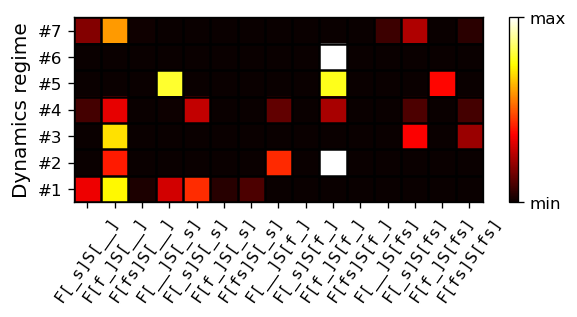

In [987]:
num_motif_ex0 = num_motif.copy()
num_motif_ex0[:, 0] = np.nan

num_motif_ex0 /= (nitr_max * tmax)
# num_motif_ex0[num_motif_ex0 == 0] = np.nan

plt.figure(figsize=(5.5, 2.))
plt.imshow(num_motif_ex0, vmax=0.7, vmin=0.1, cmap="hot", origin="lower", aspect="auto")
plt.xticks(np.arange(16), labels, rotation=55, fontfamily="monospace")
plt.yticks(np.arange(7), labels=["#%d"%(n+1) for n in range(7)])
cbar = plt.colorbar(ticks=(0.1, 0.7))
cbar.set_ticklabels(("min", "max"))
plt.ylabel("Dynamics regime", fontsize=12)

for nr in range(-1, 7):
    plt.hlines(nr+0.5, 0, 16, color="k", lw=1.5)
for nw in range(0, 16):
    plt.vlines(nw+0.5, -0.5, 6.5, color="k", lw=1.5)

plt.xlim([0.5, 15.5])
plt.show()

In [968]:
winfo = utils.load_osc_motif(6, 10, tag="", verbose=False)[0]

Loaded oscillation motif information udpated in 20240915


In [971]:
dt_set = []
for _, tl in winfo:
    dt_set.append(tl[1] - tl[0])

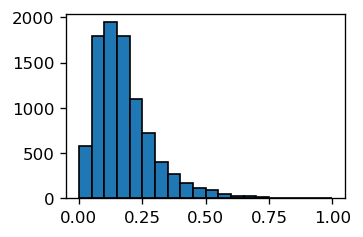

In [980]:
plt.figure(figsize=(3, 2))
plt.hist(dt_set, np.linspace(0, 1, 21), edgecolor="k")
plt.show()